In [38]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D

import sys, os
sys.path.append(os.path.abspath(".."))

from preprocessing.preprocessing_utils import clean_data, feature_selection, scale_features

In [39]:
# Load training data
data = pd.read_csv('../data/claims_train.csv')

In [40]:
data=clean_data(data)

data["Claim_rate"]=(data["ClaimNb"]/data["Exposure"]).astype(float)

data = data.drop(columns="IDpol")

numeric_cols = [c for c in ["VehPower","VehAge","DrivAge","BonusMalus", "Density"] if c in data.columns]
categorical_cols = [c for c in ["Area","VehBrand","VehGas","Region"] if c in data.columns]

data, scaler=scale_features(data, numeric_cols)

data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

PCA: Variation trade off vs pc's

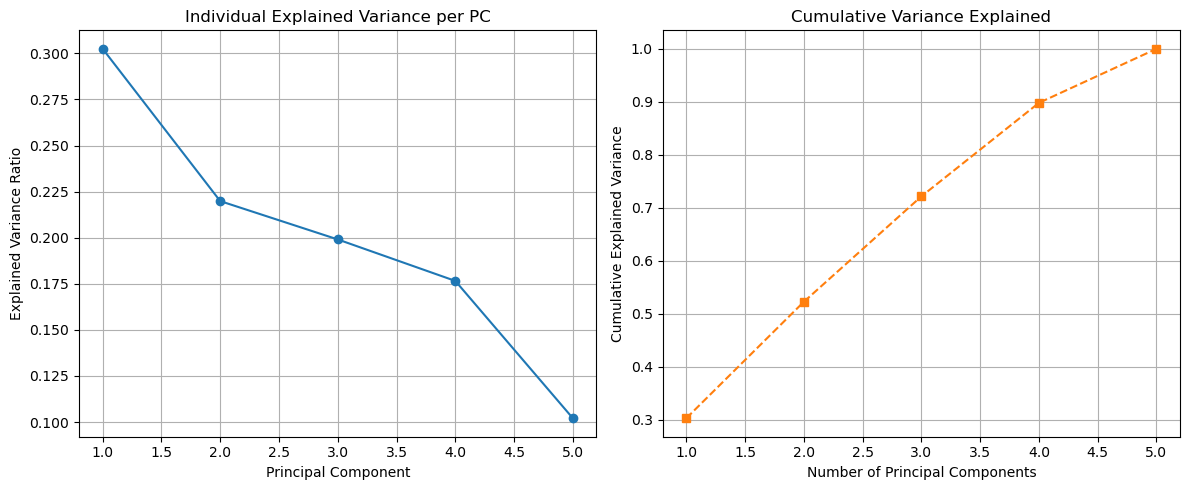

PC1: 0.302 variance, 0.302 cumulative
PC2: 0.220 variance, 0.522 cumulative
PC3: 0.199 variance, 0.721 cumulative
PC4: 0.177 variance, 0.898 cumulative
PC5: 0.102 variance, 1.000 cumulative


In [68]:
pca_full = PCA().fit(data[numeric_cols])
explained = pca_full.explained_variance_ratio_
cumulative = np.cumsum(explained)
pcs = np.arange(1, len(explained) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Individual explained variance
axes[0].plot(pcs, explained, marker='o', color='tab:blue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Individual Explained Variance per PC')
axes[0].grid(True)

# Cumulative explained variance
axes[1].plot(pcs, cumulative, marker='s', linestyle='--', color='tab:orange')
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance Explained')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print numeric summary
for i, (var, cum) in enumerate(zip(explained, cumulative)):
    print(f"PC{i+1}: {var:.3f} variance, {cum:.3f} cumulative")

In [87]:
for n in [2, 3, 4]:
    print()
    X_pca = PCA(n_components=n, random_state=42).fit_transform(data[numeric_cols])
    rng = np.random.default_rng(42)
    idx = rng.choice(len(X_pca), size=5000, replace=False)
    var = PCA(n_components=n).fit(data[numeric_cols]).explained_variance_ratio_.sum()

    print(f"\n--- {n} PCs --- variance={var:.2f} ---- ")
    for k in [2, 3, 4, 5, 6]:
        labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X_pca)
        score = silhouette_score(X_pca[idx], labels[idx])
        print(f"k={k}: silhouette={score:.3f}")



--- 2 PCs --- variance=0.52 ---- 
k=2: silhouette=0.441
k=3: silhouette=0.458
k=4: silhouette=0.348
k=5: silhouette=0.347
k=6: silhouette=0.325


--- 3 PCs --- variance=0.72 ---- 
k=2: silhouette=0.330
k=3: silhouette=0.340
k=4: silhouette=0.332
k=5: silhouette=0.280
k=6: silhouette=0.265


--- 4 PCs --- variance=0.90 ---- 
k=2: silhouette=0.286
k=3: silhouette=0.291
k=4: silhouette=0.262
k=5: silhouette=0.283
k=6: silhouette=0.238


Choose between more variance explained, and higher silhouette meaning more partitioning in data by clustering
We chose 2 pc with k=3 for a variance of 52% and silhouette score of 0.458

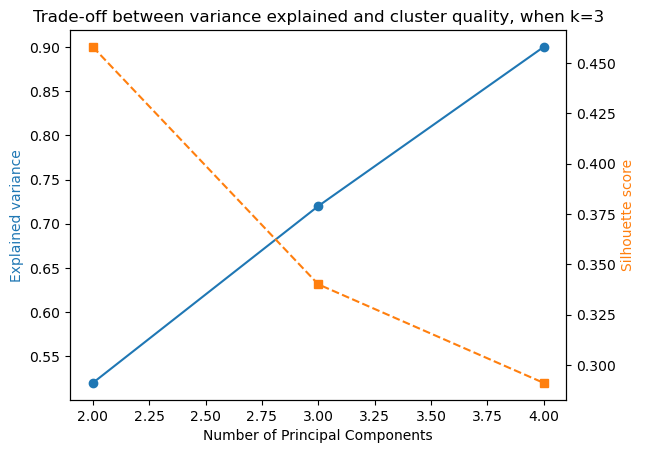

In [89]:
pcs = [2, 3, 4]
variance = [0.52, 0.72, 0.90]
sil = [0.458, 0.340, 0.291]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(pcs, variance, 'o-', color='tab:blue', label='Explained variance')
ax2.plot(pcs, sil, 's--', color='tab:orange', label='Silhouette score')

ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Explained variance', color='tab:blue')
ax2.set_ylabel('Silhouette score', color='tab:orange')
plt.title('Trade-off between variance explained and cluster quality, when k=3')
plt.show()

In [101]:
# Apply PCA with 3 components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data[numeric_cols])

print('Explained variance ratio:', np.round(pca.explained_variance_ratio_, 3))

print(pca_data.shape)

Explained variance ratio: [0.302 0.22 ]
(541416, 2)


pc1=explains 37.8 % of the variation in the data
pc2=explains 24.9 % of the variation in the data
pc3=explains 24.4 % of the variation in the data

k=2: silhouette=0.440
k=3: silhouette=0.458
k=4: silhouette=0.351
k=5: silhouette=0.352
k=6: silhouette=0.326
k=7: silhouette=0.323
k=8: silhouette=0.334
k=9: silhouette=0.328


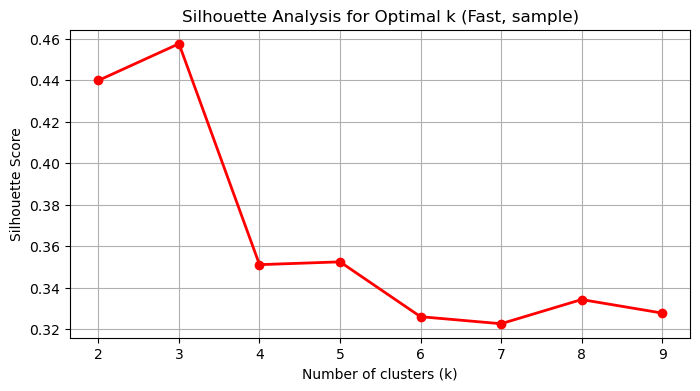

👉 Best k by silhouette score (subset): 3


In [93]:
""" Displayed why k=3 """
rng = np.random.default_rng(seed=42)
sample_frac = 1
pca_sample = pca_data[rng.choice(range(len(pca_data)), size=int(len(pca_data) * sample_frac), replace=False)]

# --- Use smaller subsample of 10.000 datapoints for speed optimization
silhouette_subsample = rng.choice(len(pca_sample), size=min(10000, len(pca_sample)), replace=False)

silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42) # runs it 10 times and finds best score n_init=10
    labels = kmeans.fit_predict(pca_sample)

    # Compute silhouette on small subset for speed
    sil = silhouette_score(pca_sample[silhouette_subsample], labels[silhouette_subsample])
    silhouette_scores.append(sil)
    print(f"k={k}: silhouette={sil:.3f}")

# --- Plot silhouette scores ---
plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, 'ro-', linewidth=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k (Fast, sample)')
plt.grid(True)
plt.show()

# --- Print best k ---
best_k = K[np.argmax(silhouette_scores)]
print(f"👉 Best k by silhouette score (subset): {best_k}")

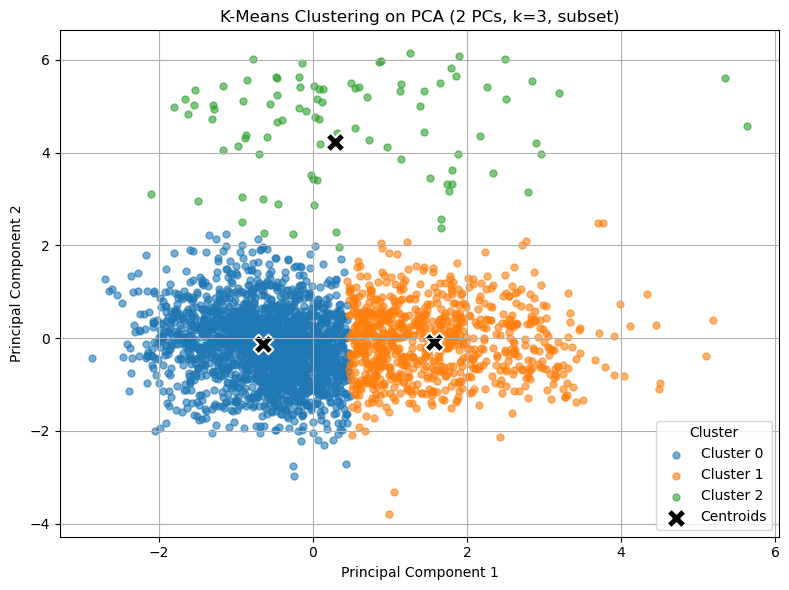

In [96]:
# --- Step 1: Fit PCA with 2 components ---
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(data[numeric_cols])

# --- Step 2: Fit K-Means with k=3 ---
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(pca_data)

# --- Step 3: Take a random subset for plotting ---
sample_size = min(3000, len(pca_data))   # plot max 3000 points
rng = np.random.default_rng(42)
sample_idx = rng.choice(len(pca_data), size=sample_size, replace=False)

pca_sample = pca_data[sample_idx]
label_sample = labels[sample_idx]

# --- Step 4: Make the plot ---
plt.figure(figsize=(8, 6))

for cluster_id in np.unique(label_sample):
    cluster_points = pca_sample[label_sample == cluster_id]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        s=25,
        alpha=0.6,
        label=f'Cluster {cluster_id}'
    )

# --- Step 5: Plot centroids (optional) ---
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='black',
    s=200,
    marker='X',
    edgecolors='white',
    linewidths=1.5,
    label='Centroids'
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering on PCA (2 PCs, k=3, subset)")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()



Top features influencing PC1:
BonusMalus    0.694880
DrivAge       0.679794
VehAge        0.176932
VehPower      0.137512
Density       0.069340
Name: PC1, dtype: float64

Top features influencing PC2:
Density       0.744569
VehAge        0.596679
VehPower      0.281432
BonusMalus    0.093391
DrivAge       0.040818
Name: PC2, dtype: float64


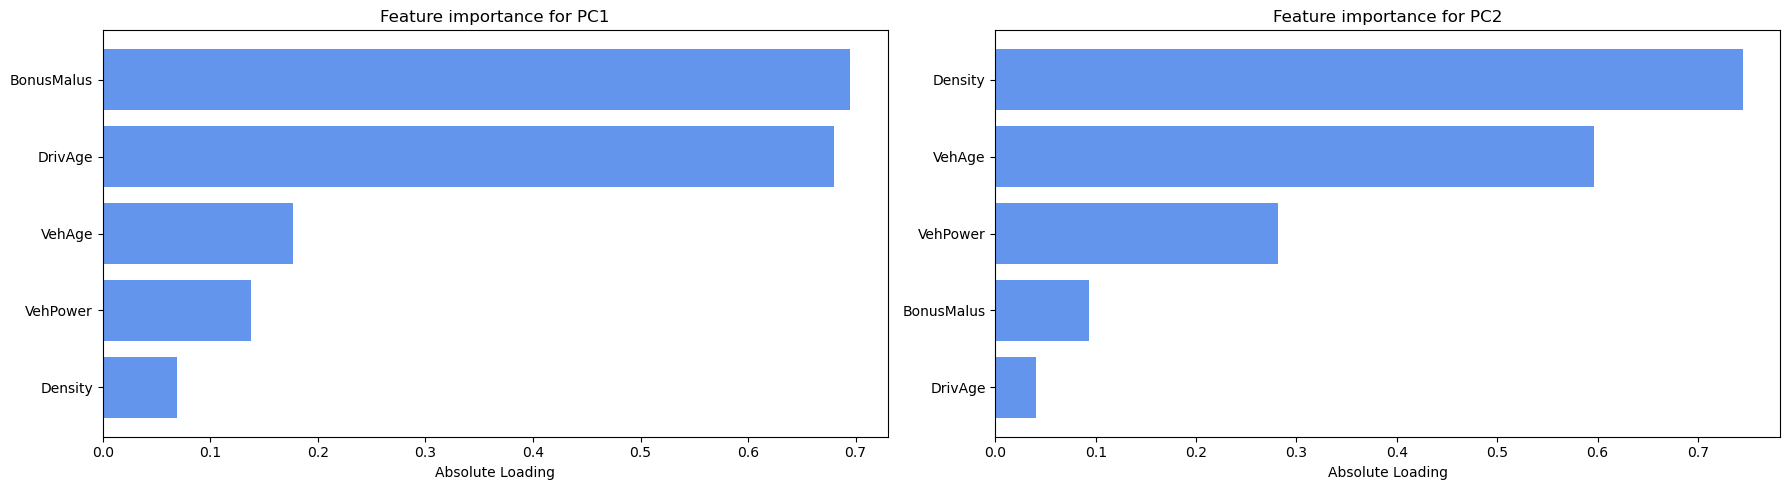

In [98]:
# --- Compute PCA loadings (feature importance) ---
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=numeric_cols)

# --- Print top features influencing each principal component ---
for i in range(pca.n_components_):
    print(f"\nTop features influencing PC{i+1}:")
    print(loadings.iloc[:, i].abs().sort_values(ascending=False).head(10))

# --- Visualize loadings (bar plots) ---
fig, axes = plt.subplots(1, pca.n_components_, figsize=(18, 5))
for i, ax in enumerate(axes):
    top_features = loadings.iloc[:, i].abs().sort_values(ascending=False)
    ax.barh(top_features.index[::-1], top_features.values[::-1], color='cornflowerblue')
    ax.set_title(f'Feature importance for PC{i+1}')
    ax.set_xlabel('Absolute Loading')
plt.tight_layout()
plt.show()

pc1=when pc1 goes up, bonusmalus and driverage also goes up. We saw earlier that cluster 1 tends to be more positive on pc1 direction and higher claim_rate so early conclusion is that claim_rate is associated with higher bonusmalus and higher driver age.
pc2=when pc2 goes up, density and vehAge and also VehPower goes up and as cluster 2 has data that has high pc2 values but they have low claim_rate we can associate high_density, high vehicleAge and high veh_power to low claim_rate????


The clustering in PCA space reveals three distinct risk segments:

Cluster 1 (High Risk): Characterized by higher values along PC1 (BonusMalus and DrivAge). These drivers show the highest average claim rate (≈0.39).

Cluster 0 (Medium Risk): Representing younger drivers with lower BonusMalus, resulting in moderate claim rates (≈0.30).

Cluster 2 (Low Risk): Positioned higher on PC2 (Density, VehPower, VehAge) and associated with lower claim rates (≈0.25). This group represents drivers or vehicles in dense areas with lower claim frequency.

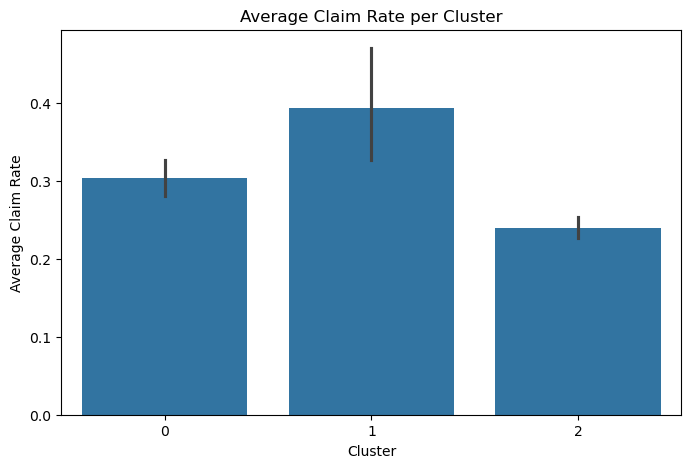

In [120]:
plt.figure(figsize=(8,5))
sns.barplot(x='Cluster', y='Claim_rate', data=data, estimator=np.mean)
plt.title('Average Claim Rate per Cluster')
plt.ylabel('Average Claim Rate')
plt.show()

In [121]:
data_original=pd.read_csv('../data/claims_train.csv')
data_original=clean_data(data_original)
# ✅ Cleaned + fixed version
data_original["Claim_rate"] = (data_original["ClaimNb"] / data_original["Exposure"]).astype(float)

# Add cluster labels from your PCA/KMeans results
data_original["Cluster"] = data["Cluster"]

# Select key columns for summary
cols = ["ClaimNb", "Exposure", "Claim_rate", "DrivAge", "VehAge", "VehPower", "BonusMalus", "Density"]
cols = [c for c in cols if c in data_original.columns]

# Compute simple cluster means + counts
summary = data_original.groupby("Cluster")[cols].mean().round(2)
summary["Count"] = data_original["Cluster"].value_counts().sort_index().values

print("\n=== Cluster Summary (mean values) ===")
print(summary)


=== Cluster Summary (mean values) ===
         ClaimNb  Exposure  Claim_rate  DrivAge  VehAge  VehPower  BonusMalus  \
Cluster                                                                         
0           0.06      0.43        0.30    31.82    8.38      6.05       78.92   
1           0.07      0.44        0.39    46.04    3.68      7.51       63.09   
2           0.05      0.57        0.24    51.08    6.63      6.58       51.81   

          Density   Count  
Cluster                    
0         1563.87  152916  
1        21493.39   14559  
2         1123.92  373941  


In [122]:
print("\nMost common Area per cluster:")
print(data_original.groupby("Cluster")["Area"].agg(lambda x: x.mode()[0]))
print("\nMost common Region per cluster:")
print(data_original.groupby("Cluster")["Region"].agg(lambda x: x.mode()[0]))
print("\nMost common Vehicle brand per cluster:")
print(data_original.groupby("Cluster")["VehBrand"].agg(lambda x: x.mode()[0]))
print("\nMost common Fuel Type per cluster:")
print(data_original.groupby("Cluster")["VehGas"].agg(lambda x: x.mode()[0]))



Most common Area per cluster:
Cluster
0    E
1    F
2    C
Name: Area, dtype: object

Most common Region per cluster:
Cluster
0    R24
1    R11
2    R24
Name: Region, dtype: object

Most common Vehicle brand per cluster:
Cluster
0     B1
1    B12
2    B12
Name: VehBrand, dtype: object

Most common Fuel Type per cluster:
Cluster
0    Regular
1    Regular
2     Diesel
Name: VehGas, dtype: object


CONCLUSION: